In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import taxcalc as tc
from taxbrain import (
    TaxBrain, differences_plot, distribution_plot, volcano_plot
)
from bokeh.io import output_notebook, show

In [45]:
output_notebook()
pd.options.display.float_format = '{:,.3f}'.format

Loading BokehJS ...

In [46]:
# Set paths to work across Mac/Windows/Linux platforms
# Update cur_path to the path of the repsitory on your local machine
cur_path = "/Users/richardevans/Docs/Economics/OSE/Federal/CharitableContrib"
data_dir = os.path.join(cur_path, 'data')
images_dir = os.path.join(cur_path, 'images')
# Directories to save data
json_dir = os.path.join(cur_path, "json")
base_dir = os.path.join(cur_path, "OUTPUT_BASELINE")
reform_dir_chddct = os.path.join(cur_path, "OUTPUT_REFORM_CHDDCT")
tmd_dir = (
    "/Users/richardevans/Docs/Economics/OSE/microsim/" +
    "tax-microdata-benchmarking/tmd/storage/output"
)

## 1. Create descriptive images

In [47]:
# Create a Pandas DataFrame of percent of filers who take the standard
# deduction.
# 2022:
# 2021: https://www.irs.gov/pub/irs-pdf/p1304.pdf
# 2020: https://www.irs.gov/pub/irs-soi/soi-a-inpr-id2201.pdf
# 2019: https://www.irs.gov/pub/irs-prior/p1304--2021.pdf
# 2018: https://www.irs.gov/pub/irs-prior/p1304--2020.pdf
# 2017: https://www.irs.gov/pub/irs-soi/17inintaxreturns.pdf
# 2016: https://www.irs.gov/pub/irs-soi/16inintaxreturns.pdf
# 2015: https://www.irs.gov/pub/irs-soi/15inintaxreturns.pdf
pct_std_deduct = pd.DataFrame({
    'year': [2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015],
    'pct_std_deduct': [88.6, 88.2, 87.5, 88.9, 87.3, 68.0, 68.6, 69.0],
    'std_deduct_joint': [
        25900, 25100, 24800, 24400, 24000, 12700, 12600, 12600
    ],
    'std_deduct_single': [
        12950, 12550, 12400, 12200, 12000, 6350, 6300, 6300
    ],
    'chtbl_deduct_nonitem_joint': [0, 600, 300, 0, 0, 0, 0, 0],
    'chtbl_deduct_nonitem_other': [0, 300, 150, 0, 0, 0, 0, 0],
})
pct_std_deduct['std_deduct_plus_joint'] = (
    pct_std_deduct['std_deduct_joint'] +
    pct_std_deduct['chtbl_deduct_nonitem_joint']
)
pct_std_deduct['std_deduct_plus_other'] = (
    pct_std_deduct['std_deduct_single'] +
    pct_std_deduct['chtbl_deduct_nonitem_other']
)

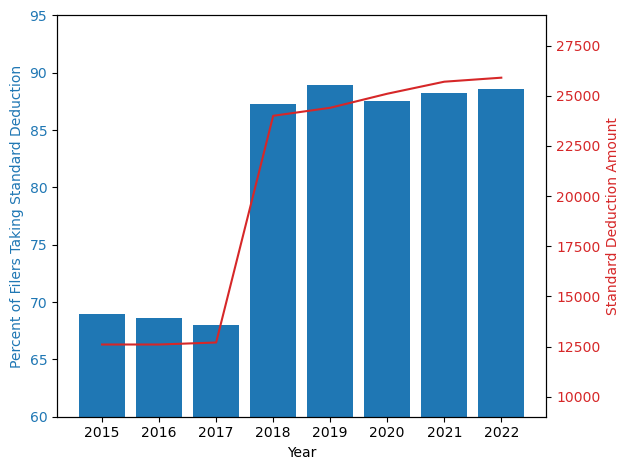

In [48]:
# Make a plot with a left y-axis for the percent of filers who take the
# standard deduction and a right y-axis for the std_deduct_joint amount.
fig1, ax1 = plt.subplots()
color_pct = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent of Filers Taking Standard Deduction', color=color_pct)
ax1.bar(
    pct_std_deduct['year'], pct_std_deduct['pct_std_deduct'], color=color_pct,
    label='Percent of Filers Taking Standard Deduction'
)
ax1.tick_params(axis='y', labelcolor=color_pct)
ax2 = ax1.twinx()
color_std = 'tab:red'
ax2.set_ylabel('Standard Deduction Amount', color=color_std)
ax2.plot(
    pct_std_deduct['year'], pct_std_deduct['std_deduct_plus_joint'],
    color=color_std, label='Standard Deduction Amount (married, joint)'
)
ax2.tick_params(axis='y', labelcolor=color_std)
# Set ax1 y-axis limits to 20-100 and ax2 y-axis limits to 10000-30000.
ax1.set_ylim(60, 95)
ax2.set_ylim(9000, 29000)
# Put a note below the plot with the source of the data.
# sub_plot_text = (
#     "Note: Percent of filers taking the standard deduction data come from the IRS year-end complete reports. The standard deduction amount comes these same reports. The standard deduction amounts include the above-the-line charitable deduction amounts for non-itemizers in 2020 and 2021."
# )
# plt.figtext(
#     0.5, 0.01, sub_plot_text, wrap=True, horizontalalignment='center', fontsize=12
# )
fig1.tight_layout()
# plt.title(
#     'Percent of Filers Taking Standard Deduction and Standard Deduction Amount'
# )
# plt.legend(loc='upper left')
# Save the plot as StdDeduct_pct_take.png in the images_dir directory.
plt.savefig(os.path.join(images_dir, 'StdDeduct_pct_take.png'))
plt.show()

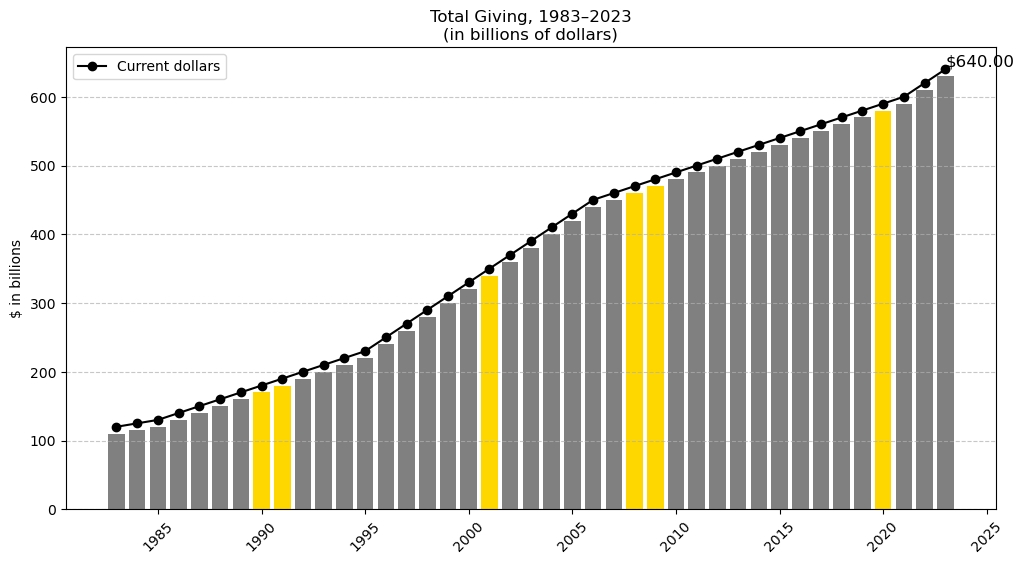

In [49]:
# Manually adjusted data to closely match the original chart
years = np.arange(1983, 2024)
total_giving_current = [120, 125, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 620, 640]  # Updated values
inflation_adjusted = [110, 115, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 610, 630]  # Adjusted to match better

# Mark recession years (as seen in yellow bars)
recession_years = {1990, 1991, 2001, 2008, 2009, 2020}  # Example years

plt.figure(figsize=(12, 6))

# Plot inflation-adjusted dollars as bars
for year, value in zip(years, inflation_adjusted):
    color = 'gold' if year in recession_years else 'gray'
    plt.bar(year, value, color=color)

# Plot current dollars as a line plot
plt.plot(years, total_giving_current, marker='o', color='black', linestyle='-', label='Current dollars')

# Annotate the last value
plt.text(years[-1], total_giving_current[-1], f'${total_giving_current[-1]:.2f}', fontsize=12, verticalalignment='bottom')

# Labels and legend
plt.title("Total Giving, 1983–2023\n(in billions of dollars)")
plt.ylabel("$ in billions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [50]:
# Read in data
item_by_agi_dir = os.path.join(data_dir, "IRS_SOI/item_by_agi")
item_by_age_dir = os.path.join(data_dir, "IRS_SOI/item_by_age")
inc_range_lst = [
    "all_returns_total", "under_5k", "5k-10k", "10k-15k", "15k-20k", "20k-25k",
    "25k-30k", "30k-35k", "35k-40k", "40k-45k", "45k-50k", "50k-55k",
    "55k-60k", "60k-75k", "75k-100k", "100k-200k", "200k-500k", "500k-1m",
    "1m-1.5m", "1.5m-2m", "2m-5m", "5m-10m", "10m_over",
    "taxable_returns_total", "nontaxable_returns_total"
]
age_range_lst = [
    "all_returns", "under_18", "18-25", "26-34", "35-44", "45-54", "55-64",
    "65_over"
]
var_list = [
    "num_returns", "agi_less_def", "total_income", "item_ded_tot",
    "contrib_num", "contrib_tot"
]
var_col_sheet_names_agi = [
    ["B", "C", "E", "BH", "CS", "CT"],
    ["B", "C", "E", "BH", "CS", "CT"],
    ["B", "C", "E", "BJ", "CU", "CV"],
    ["B", "C", "E", "BL", "CY", "CZ"],
    ["B", "C", "E", "BN", "DC", "DD"],
    ["B", "C", "E", "BJ", "CY", "CZ"],
    ["B", "C", "E", "BH", "CW", "CX"],
    ["B", "C", "E", "BT", "DG", "DH"]]
# Create blank DataFrame for data by AGI and data by age for each variable with
# dates as rows and income ranges or age ranges as columns/variables
year_lst = list(range(2015, 2023))
for var in var_list:
    if var == "num_returns" or var == "contrib_num":
        data_type = "int64"
    else:
        data_type = "float64"
    exec(
        f"{var}_age_df = pd.DataFrame(columns=['year']+age_range_lst, dtype=np.{data_type})"
    )
    exec(
        f"{var}_agi_df = pd.DataFrame(columns=['year']+inc_range_lst, dtype=np.{data_type})"
    )

for ind_year, year in enumerate(year_lst):  # Loop through years 2015 to 2022
    two_digit_year = str(year)[2:]  # Get the last two digits of the year
    for ind_var, var in enumerate(var_list):
        print(year, var)
        # Add a row to the DataFrame and set the year = year
        exec(f"{var}_age_df.loc[ind_year, 'year'] = year")
        exec(f"{var}_agi_df.loc[ind_year, 'year'] = year")
        # Create a list from the column of an xls file
        age_data = pd.read_excel(
            os.path.join(item_by_age_dir, f"{two_digit_year}in26ag.xls"),
            sheet_name="TBL21", header=None, names=["variable"],
            usecols=var_col_sheet_names_agi[ind_year][ind_var],
            skiprows=9, nrows=8
        )["variable"].tolist()
        exec(f"{var}_age_df.loc[ind_year, age_range_lst] = age_data")
        agi_data = pd.read_excel(
            os.path.join(item_by_agi_dir, f"{two_digit_year}in21id.xls"),
            sheet_name="TBL21", header=None, names=["variable"],
            usecols=var_col_sheet_names_agi[ind_year][ind_var],
            skiprows=9, nrows=25
        )["variable"].tolist()
        exec(f"{var}_agi_df.loc[ind_year, inc_range_lst] = agi_data")

irs_soi_data_dct = {
    "num_returns_age": num_returns_age_df,
    "agi_less_def_age": agi_less_def_age_df,
    "total_income_age": total_income_age_df,
    "item_ded_tot_age": item_ded_tot_age_df,
    "contrib_num_age": contrib_num_age_df,
    "contrib_tot_age": contrib_tot_age_df,
    "num_returns_agi": num_returns_agi_df,
    "agi_less_def_agi": agi_less_def_agi_df,
    "total_income_agi": total_income_agi_df,
    "item_ded_tot_agi": item_ded_tot_agi_df,
    "contrib_num_agi": contrib_num_agi_df,
    "contrib_tot_agi": contrib_tot_agi_df
}


2015 num_returns
2015 agi_less_def
2015 total_income
2015 item_ded_tot
2015 contrib_num
2015 contrib_tot
2016 num_returns
2016 agi_less_def
2016 total_income
2016 item_ded_tot
2016 contrib_num
2016 contrib_tot
2017 num_returns
2017 agi_less_def
2017 total_income
2017 item_ded_tot
2017 contrib_num
2017 contrib_tot
2018 num_returns
2018 agi_less_def
2018 total_income
2018 item_ded_tot
2018 contrib_num
2018 contrib_tot
2019 num_returns
2019 agi_less_def
2019 total_income
2019 item_ded_tot
2019 contrib_num
2019 contrib_tot
2020 num_returns
2020 agi_less_def
2020 total_income
2020 item_ded_tot
2020 contrib_num
2020 contrib_tot
2021 num_returns
2021 agi_less_def
2021 total_income
2021 item_ded_tot
2021 contrib_num
2021 contrib_tot
2022 num_returns
2022 agi_less_def
2022 total_income
2022 item_ded_tot
2022 contrib_num
2022 contrib_tot


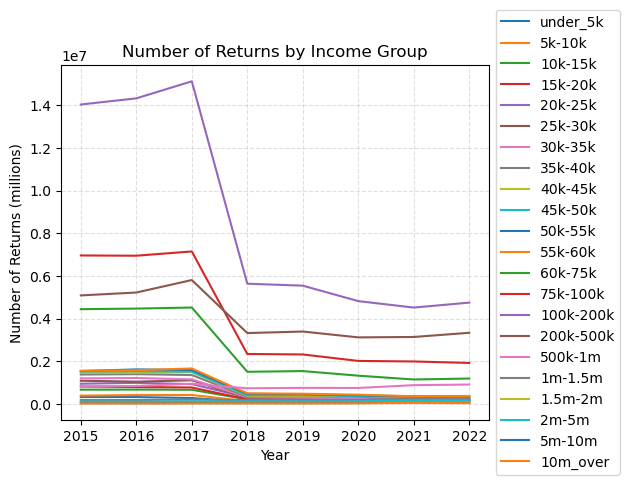

In [51]:
# Plot the time series of number of returns by income group
for var in inc_range_lst:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        plt.plot(num_returns_agi_df['year'], num_returns_agi_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Number of Returns (millions)')
plt.title('Number of Returns by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'NumReturns_inc.png'))
plt.show()

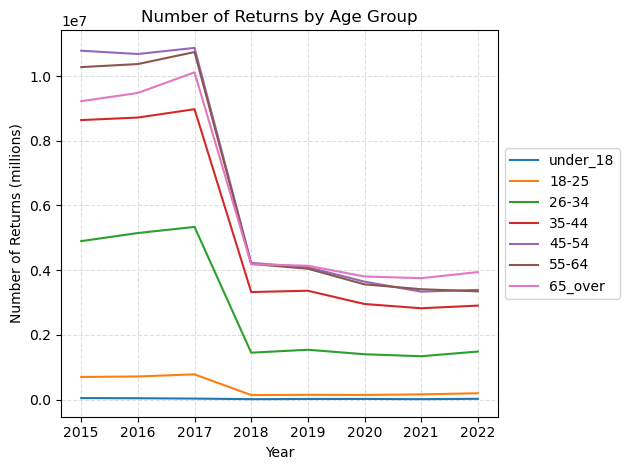

In [52]:
# Plot the time series of number of returns by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(num_returns_age_df['year'], num_returns_age_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Number of Returns (millions)')
plt.title('Number of Returns by Age Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'NumReturns_age.png'))
plt.show()

In [53]:
# Create a percent change variable for the series contrib_tot_agi_df["all_returns_total"]
contrib_tot_agi_df["all_returns_total_pct_change"] = (
    contrib_tot_agi_df["all_returns_total"].pct_change() * 100
)
# Create a simple difference variable for the series contrib_tot_agi_df["all_returns_total"]
contrib_tot_agi_df["all_returns_total_diff"] = (
    contrib_tot_agi_df["all_returns_total"].diff()
) * 1_000
contrib_tot_agi_df[["year", "all_returns_total", "all_returns_total_diff", "all_returns_total_pct_change"]]

,year,all_returns_total,all_returns_total_diff,all_returns_total_pct_change
0,"2,015.000","221,850,264.000",NaN,NaN
1,"2,016.000","233,867,324.000","12,017,060,000.000",5.417
2,"2,017.000","256,064,685.000","22,197,361,000.000",9.491
3,"2,018.000","196,956,414.000","-59,108,271,000.000",-23.083
4,"2,019.000","190,114,194.000","-6,842,220,000.000",-3.474
5,"2,020.000","204,663,042.000","14,548,848,000.000",7.653
6,"2,021.000","263,250,541.000","58,587,499,000.000",28.626
7,"2,022.000","222,384,855.000","-40,865,686,000.000",-15.523


/var/folders/d4/trj3dssd6s3g8kxvjmczz11w0000gn/T/ipykernel_17861/4291640844.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


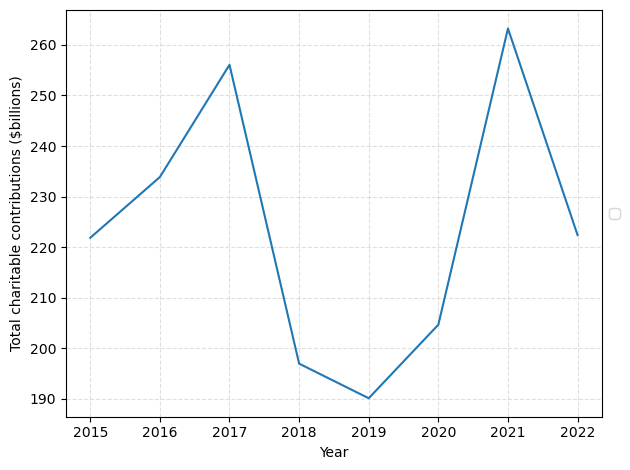

In [54]:
plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df["all_returns_total"] * 1_000 / 1e9)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total charitable contributions ($billions)')
# plt.title('Total cash and noncash charitable contributions: 2015-2022')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContributions.png'))
plt.show()

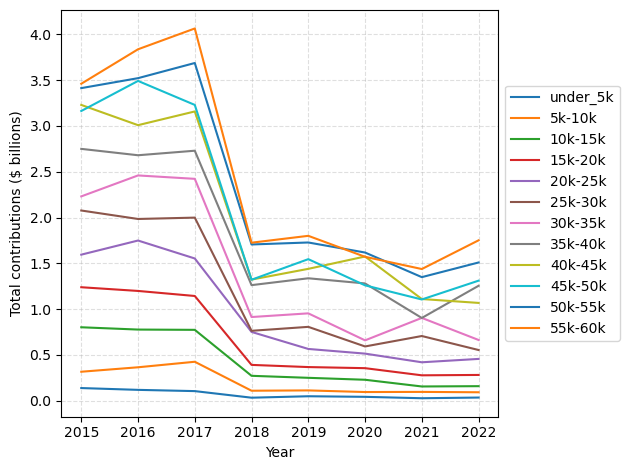

In [58]:
# Plot the time series of total contributions amount by income group
for var in inc_range_lst[:13]:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        # if var in ["2m-5m", "5m-10m", "10m_over"]:
        #     plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df[var], label=var, color='black')
        # else:
        #     plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df[var], label=var)
        plt.plot(
            contrib_tot_agi_df['year'], contrib_tot_agi_df[var] * 1_000 / 1e9,
            label=var
        )
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions ($ billions)')
# plt.title('Total charitable contributions by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_inc.png'))
plt.show()

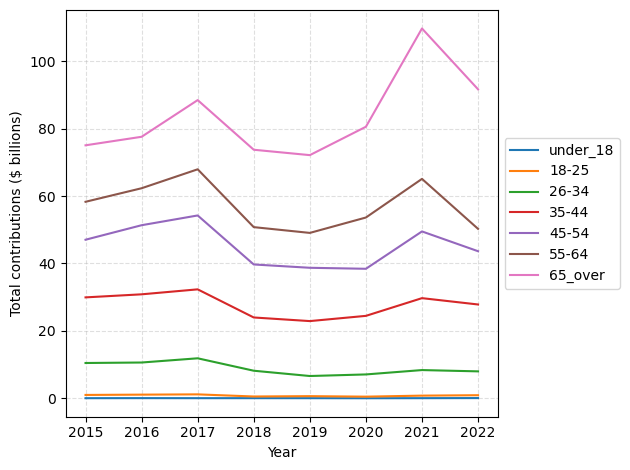

In [43]:
# Plot the time series of total contributions amount by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(
            contrib_tot_age_df['year'], contrib_tot_age_df[var] * 1_000 / 1e9,
            label=var
        )
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions ($ billions)')
# plt.title('Total charitable contributions by Age Group: 2015-2022')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_age.png'))
plt.show()

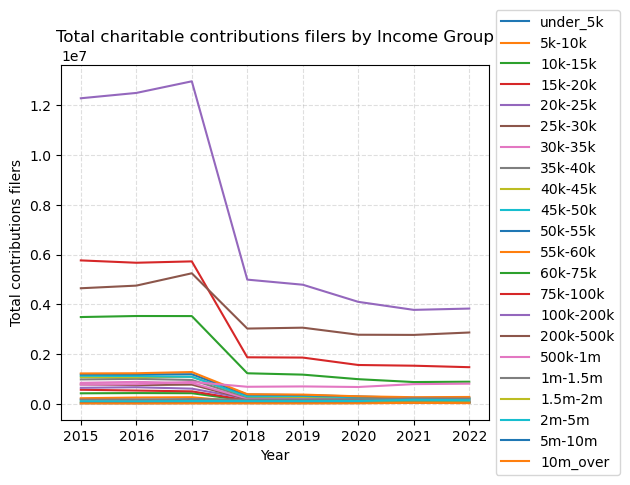

In [11]:
# Plot the time series of total contributions filers by income group
for var in inc_range_lst:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        plt.plot(contrib_num_agi_df['year'], contrib_num_agi_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions filers')
plt.title('Total charitable contributions filers by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_num_inc.png'))
plt.show()

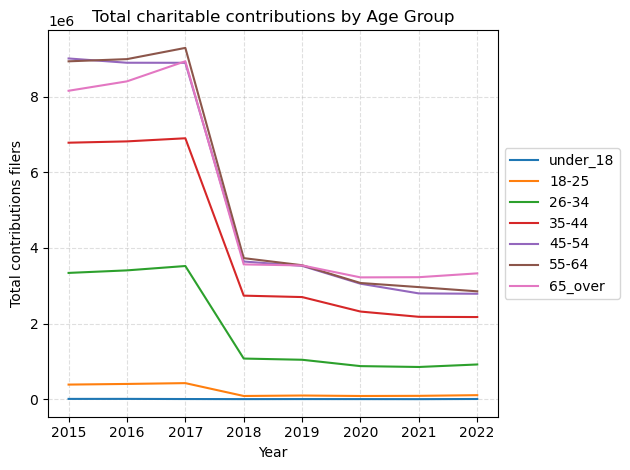

In [12]:
# Plot the time series of total contributions filers amount by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(contrib_num_age_df['year'], contrib_num_age_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions filers')
plt.title('Total charitable contributions by Age Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_num_age.png'))
plt.show()

## 2. Run Tax-Calculator analysis

### 2.1. Setup baseline calculator

In [71]:
# Set up the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
gfactors=tc.growfactors.GrowFactors(
    growfactors_filename=os.path.join(tmd_dir, "tmd_growfactors.csv")
)
rec = tc.records.Records(
    data=os.path.join(tmd_dir, "tmd.csv.gz"),
    start_year=tc.records.Records.TMDCSV_YEAR,
    gfactors=gfactors,
    weights=os.path.join(tmd_dir, "tmd_weights.csv.gz"),
    adjust_ratios=None,
)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)
print("taxcalc TMD start year is:", tc.records.Records.TMDCSV_YEAR)


taxcalc TMD start year is: 2021


### 2.2. Setup reform calculator

In [72]:
ref_pol = tc.policy.Policy()
ref_pol.implement_reform(base_pol_dict)
ref_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "chddct.json"))
ref_pol.implement_reform(ref_pol_dict)
tc_ref = tc.calculator.Calculator(policy=ref_pol, records=rec)

### 2.3. Create the revenue estimates for 10-year budget window

In [73]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
start_year = 2026
end_year = 2035

rev_base = {'IIT': {}, 'Payroll': {}}
rev_ref = {'IIT': {}, 'Payroll': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_base.calc_all()
    rev_base['IIT'][t] = tc_base.weighted_total('iitax')
    rev_base['Payroll'][t] = tc_base.weighted_total('payrolltax')
    tc_ref.advance_to_year(t)
    tc_ref.calc_all()
    rev_ref['IIT'][t] = tc_ref.weighted_total('iitax')
    rev_ref['Payroll'][t] = tc_ref.weighted_total('payrolltax')

ValidationError: {
    "errors": {
        "year": "['Input 2035 must be less than 2034.']"
    }
}

### 2.4. Create a table of output

In [70]:
# make table of revenue estimates
rev_base_df = pd.DataFrame.from_dict(rev_base).T
rev_ref_df = pd.DataFrame.from_dict(rev_ref).T
print("Test")
print(rev_base_df - rev_ref_df)
diff_df = (rev_ref_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff_df['2025-2034'] = diff_df.sum(axis=1)
print('Charitable Act revenue estimates')
print(rev_base_df * 1e-9)
print(rev_ref_df)
print(diff_df.to_markdown())

Test
                   2025            2026            2027            2028  \
IIT     $-428729502.980 $-452243370.310 $-474449137.455 $-497179965.951   
Payroll          $0.000          $0.000          $0.000          $0.000   

                   2029            2030            2031            2032  \
IIT     $-520437357.669 $-545272306.652 $-571188125.373 $-598291266.435   
Payroll          $0.000          $0.000          $0.000          $0.000   

                   2033            2034  
IIT     $-625888850.100 $-654180486.424  
Payroll          $0.000          $0.000  
Charitable Act revenue estimates
           2025    2026    2027    2028    2029    2030    2031    2032  \
IIT     $25.208 $26.292 $27.377 $28.536 $29.803 $31.112 $32.476 $33.896   
Payroll $15.502 $16.217 $16.885 $17.530 $18.201 $18.895 $19.605 $20.327   

           2033    2034  
IIT     $35.345 $36.838  
Payroll $21.058 $21.801  
                    2025             2026             2027             2028  \
I

# IGNORE BELOW HERE

In [14]:
# specify Tax-Brain object
# We use the TCJA extended baseline and the TMD data
TMD_dict = {
    "data": os.path.join(tmd_dir, "tmd.csv.gz"),
    "start_year": start_year,
    "growfactors": os.path.join(tmd_dir, "tmd_growfactors.csv"),
    "weights": os.path.join(tmd_dir, "tmd_weights.csv.gz"),
}
# tb_static = TaxBrain(
#     start_year, end_year, microdata=TMD_dict,
#     base_policy=ref_base, reform=ref_chddct
# )
tb_static = TaxBrain(
    start_year, end_year, microdata=TMD_dict,
    base_policy={}, reform=ref_chddct
)
# Simulate the model
tb_static.run()

In [15]:
# print tables
print("Combined Tax Liability Over the Budget Window")
print((tb_static.weighted_totals("combined", include_total=True) / 1e9).to_markdown())  # division to put in billions, make sure this is correct. Look at Jason's notebook.
# Also see JEC report JCX-11-20 (March 26, 2020, line 4, https://www.jct.gov/getattachment/2245461c-dd37-451e-93fd-d1c62e074087/x-11-20-5252.pdf)

Combined Tax Liability Over the Budget Window
|            |      2025 |     2026 |      2027 |      2028 |      2029 |      2030 |      2031 |      2032 |      2033 |      2034 |     Total |
|:-----------|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| Base       | 34.0086   | 37.7756  | 39.2285   | 40.7546   | 42.2727   | 44.0092   | 45.8121   | 47.6635   | 49.5095   | 51.4548   | 432.489   |
| Reform     | 34.3512   | 38.2945  | 39.7733   | 41.3256   | 42.8674   | 44.6323   | 46.4646   | 48.3465   | 50.2227   | 52.2      | 438.478   |
| Difference |  0.342534 |  0.51889 |  0.544772 |  0.570944 |  0.594722 |  0.623088 |  0.652509 |  0.682985 |  0.713179 |  0.745145 |   5.98877 |


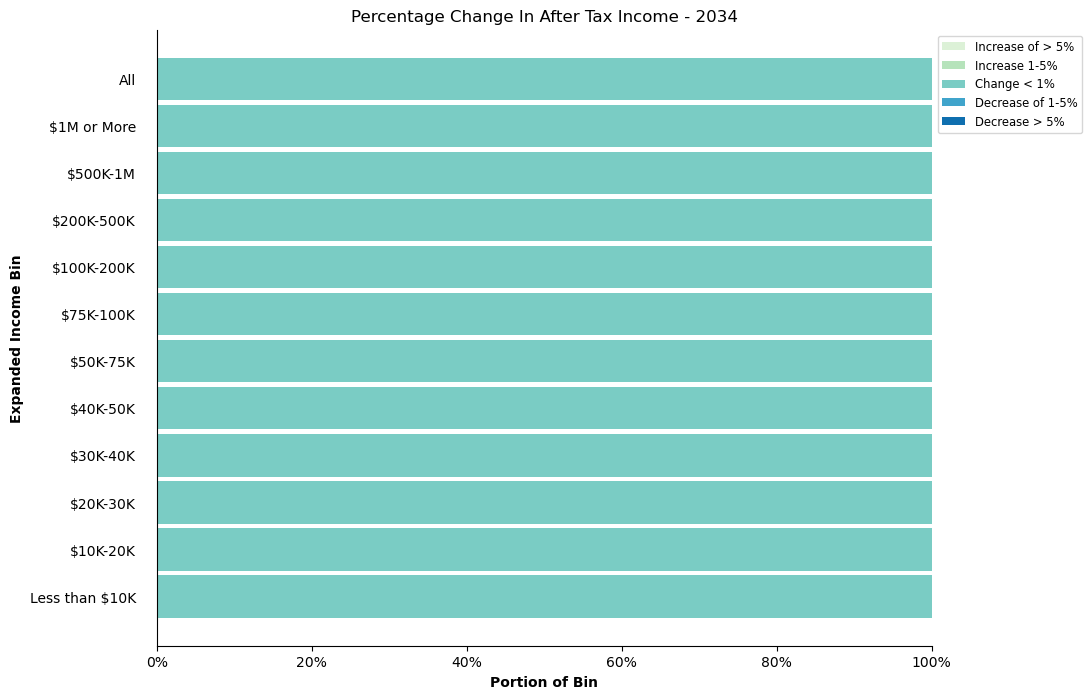

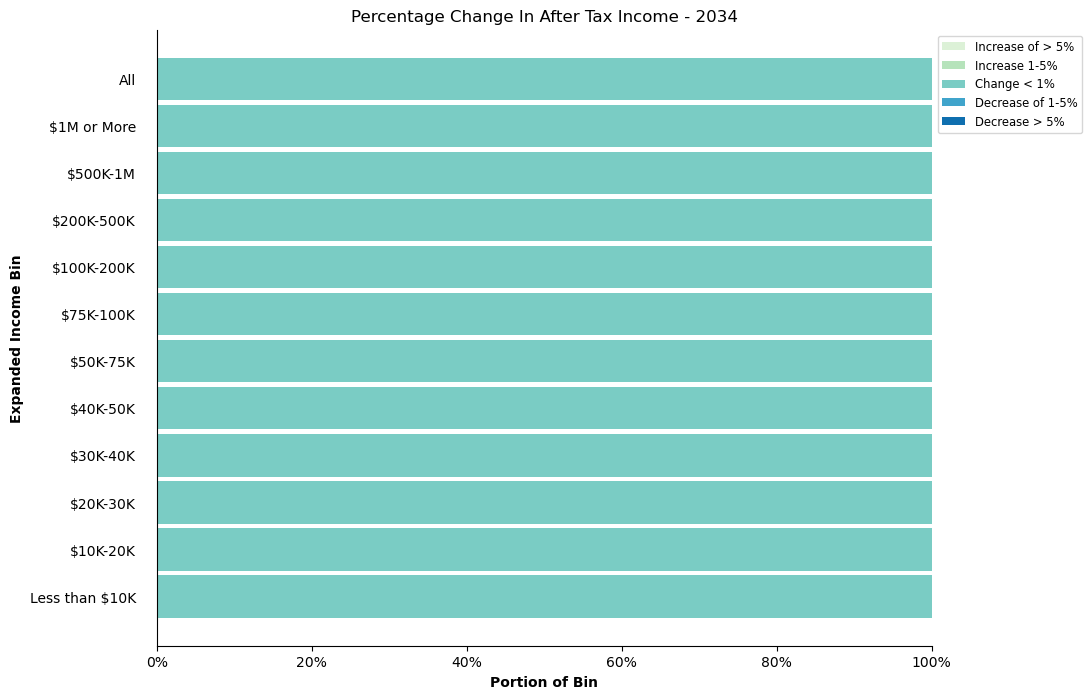

In [15]:
# Create distributional analysis bar plot
distribution_plot(tb_static, 2034, figsize=(10, 8))

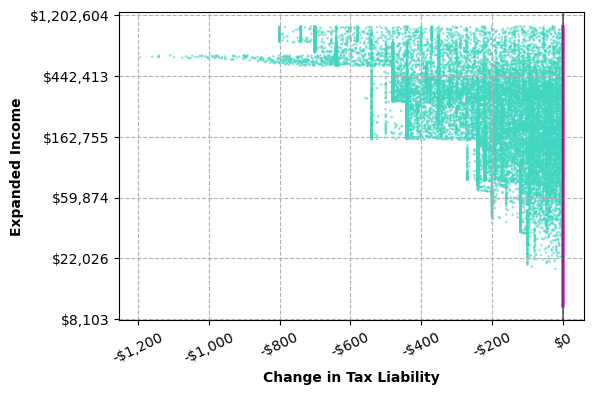

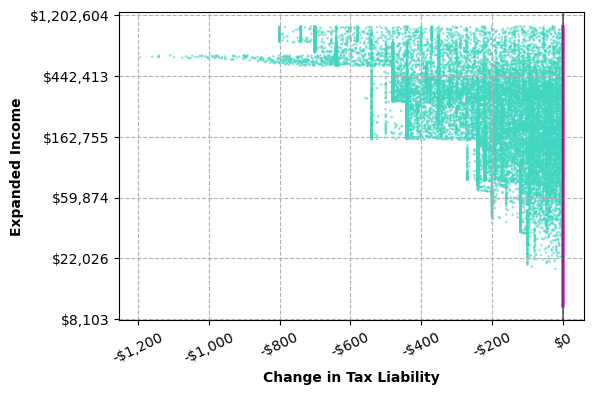

In [16]:
# Create volcano plot
volcano_plot(tb_static, year=2034, y_var="c00100", max_y=1_000_000, min_y=10_000)

### 2.2. Dynamic analysis (behavioral response)